**RNN time series forecast**


In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

**Generate a series to evaluate various models**

In [62]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):  # Adds a trend to a series
    return slope * time

def seasonal_pattern(season_time):  # Defines a cycle
        return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):  # Adds a recuring cycle to a series
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):  # Adds noice to a series
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

**Create series with trend, recurring pattern, and noise**


series shape:  (1461,)
first window:
 [60.       59.938343 59.743538 59.416134 58.957005 58.367393 57.648876
 56.8034   55.833214 54.74093  53.52947  52.202076 50.762306 49.214005
 47.56132  45.808666 43.96073  42.02247  39.999043 37.895866]


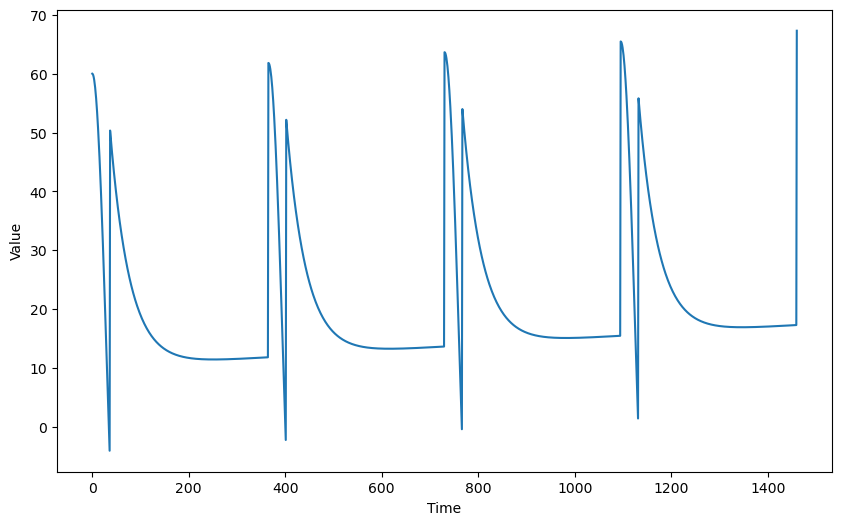

In [73]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 0
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    
print ('series shape: ',np.shape(G.SERIES))
print('first window:\n',G.SERIES[0:20])
    
# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

**Do Train / Validation split**


In [91]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

print(series_train.shape)

(1100,)


**Create TF Dataset**

In [79]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    #dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

for element in dataset:
    print ('dataset is:   ',type(dataset))
    print ('              ',  dataset)
    print ('\nelement is:   ',type(element))
    print ('element[0] is:',np.shape(element[0]))
    print('\nfirst element[0][0]:\n',element[0][0])

    break


dataset is:    <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
               <PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>

element is:    <class 'tuple'>
element[0] is: (32, 20)

first element[0][0]:
 tf.Tensor(
[60.       59.938343 59.743538 59.416134 58.957005 58.367393 57.648876
 56.8034   55.833214 54.74093  53.52947  52.202076 50.762306 49.214005
 47.56132  45.808666 43.96073  42.02247  39.999043 37.895866], shape=(20,), dtype=float32)


**Create model**

In [81]:
def create_uncompiled_model():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 
    
    return model

In [92]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

result=uncompiled_model.predict(dataset)
print(type(result))
print(result.shape)  #train lenght minus window

<class 'numpy.ndarray'>
(1080, 1)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [8]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8,momentum=.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [9]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 6s 12ms/step - loss: 8.9200 - mae: 9.4044
Epoch 2/100
34/34 [==============================] - 0s 10ms/step - loss: 4.6019 - mae: 5.0664
Epoch 3/100
34/34 [==============================] - 0s 10ms/step - loss: 4.3568 - mae: 4.8221
Epoch 4/100
34/34 [==============================] - 0s 11ms/step - loss: 4.1927 - mae: 4.6521
Epoch 5/100
34/34 [==============================] - 0s 11ms/step - loss: 4.1104 - mae: 4.5753
Epoch 6/100
34/34 [==============================] - 0s 11ms/step - loss: 3.9530 - mae: 4.4138
Epoch 7/100
34/34 [==============================] - 0s 11ms/step - loss: 3.8185 - mae: 4.2773
Epoch 8/100
34/34 [==============================] - 0s 11ms/step - loss: 3.7163 - mae: 4.1817
Epoch 9/100
34/34 [==============================] - 0s 11ms/step - loss: 3.5957 - mae: 4.0526
Epoch 10/100
34/34 [==============================] - 0s 11ms/step - loss: 3.5528 - mae: 4.0098
Epoch 11/100
34/34 [=============================

Epoch 86/100
34/34 [==============================] - 0s 11ms/step - loss: 92.1675 - mae: 92.6675
Epoch 87/100
34/34 [==============================] - 0s 11ms/step - loss: 104.5554 - mae: 105.0554
Epoch 88/100
34/34 [==============================] - 0s 10ms/step - loss: 117.2302 - mae: 117.7302
Epoch 89/100
34/34 [==============================] - 0s 11ms/step - loss: 130.2429 - mae: 130.7429
Epoch 90/100
34/34 [==============================] - 0s 11ms/step - loss: 136.3694 - mae: 136.8687
Epoch 91/100
34/34 [==============================] - 0s 11ms/step - loss: 382.9924 - mae: 383.4924
Epoch 92/100
34/34 [==============================] - 0s 11ms/step - loss: 489.3209 - mae: 489.8209
Epoch 93/100
34/34 [==============================] - 0s 11ms/step - loss: 450.3473 - mae: 450.8473
Epoch 94/100
34/34 [==============================] - 0s 11ms/step - loss: 673.0654 - mae: 673.5654
Epoch 95/100
34/34 [==============================] - 0s 12ms/step - loss: 801.9454 - mae: 802.4454
Ep

(1e-06, 1.0, 0.0, 30.0)

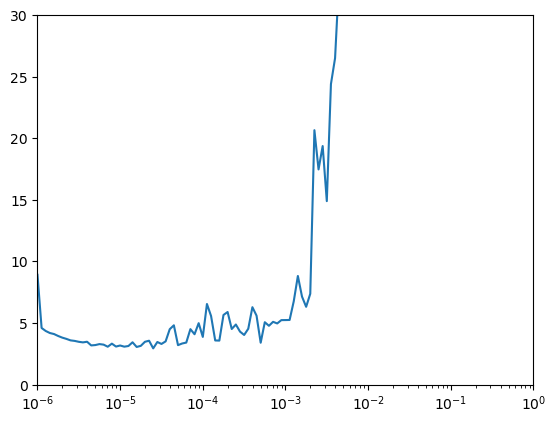

In [10]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [11]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=2e-5,momentum=.9), 
                  metrics=["mae"])   
    
    ### END CODE HERE

    return model

In [12]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 6s 12ms/step - loss: 15.4859 - mae: 15.9772
Epoch 2/50
34/34 [==============================] - 0s 11ms/step - loss: 4.4039 - mae: 4.8695
Epoch 3/50
34/34 [==============================] - 0s 11ms/step - loss: 4.0823 - mae: 4.5527
Epoch 4/50
34/34 [==============================] - 0s 10ms/step - loss: 3.6753 - mae: 4.1454
Epoch 5/50
34/34 [==============================] - 0s 10ms/step - loss: 3.4522 - mae: 3.9157
Epoch 6/50
34/34 [==============================] - 0s 10ms/step - loss: 3.5864 - mae: 4.0558
Epoch 7/50
34/34 [==============================] - 0s 11ms/step - loss: 3.2437 - mae: 3.7093
Epoch 8/50
34/34 [==============================] - 0s 10ms/step - loss: 3.2050 - mae: 3.6693
Epoch 9/50
34/34 [==============================] - 0s 10ms/step - loss: 3.1976 - mae: 3.6660
Epoch 10/50
34/34 [==============================] - 0s 10ms/step - loss: 3.1683 - mae: 3.6329
Epoch 11/50
34/34 [==============================] - 0s 1

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [13]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

## Faster model forecasts

In the previous week you used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:

- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

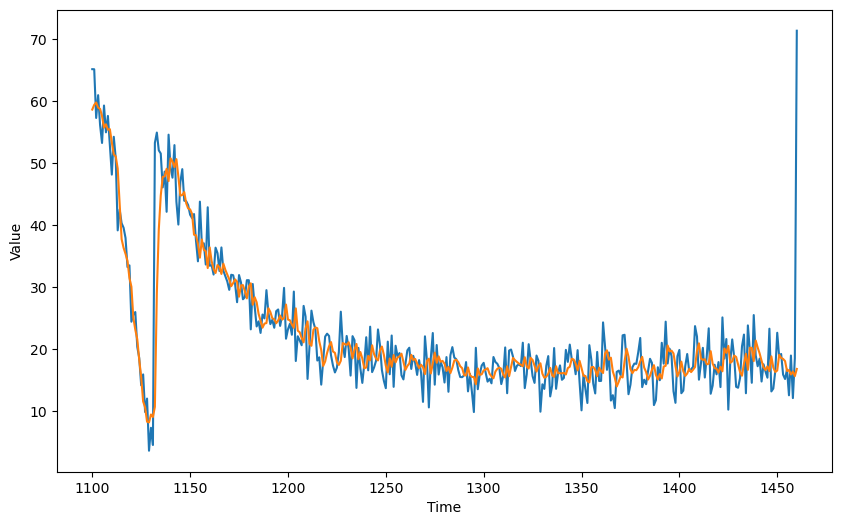

In [16]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/expected.png" width="500"/>
</div>

In [17]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 28.11, mae: 3.16 for forecast


**To pass this assignment your forecast should achieve an MAE of 4.5 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a `tar` file which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy `SavedModel` directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**


- Unlike last week, this time the model is saved using the `SavedModel` format. This is done because the HDF5 format does not fully support `Lambda` layers.

In [36]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets
tar: les (x86)\dotnet\;C:????dddd, MMMM d, yyyy: Couldn't visit directory: No such file or directory
tar: Error exit delayed from previous errors.


**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging Tensorflow's layers for sequence modelling such as `RNNs` and `LSTMs`! **This resulted in a forecast that matches (or even surpasses) the one from last week while training for half of the epochs.**

**Keep it up!**